# Capstone Project - Traffic Accident Severity Prediction
Applied Data Science Capstone by IBM/Coursera

## Introduction <a name="introduction"></a>

Traffic accident has been a great threat to public health and security. It causes the loss of properties and lives, for both individual and society. Traffic accident severity prediction research recognize the key factors that contribute to a car accident. Successful prediction can improve the public traffic safety and transportation efficiency by multiple measurements, such as reinforce aged infrastructure in critical spots to reduce the accidental risk, redistribute assistance resource for timely rescue in case of emergency, alert divers to pay more attention to accident-prone condition and so on. 

This project examines the collisions data of Seattle since 2004 till 2020, compares different classification algorithms to select the best model for accident prediction, and identifies some dangerous situations for drivers by clustering to formulate appropriate prevention strategies and actions.



## Data <a name="data"></a>

**Data source**<br>

Collisions - Seattle GeoData - ArcGIS Online: https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0
<br>
Attribute Information: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
<br>
GeoJService: https://gisdata.seattle.gov/server/rest/services/SDOT/SDOT_Collisions/MapServer/0/query?outFields=*&where=1%3D1
<br>
GeoJSON: https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.geojson

The source includes all types of collisions data in Seattle city from 2014/01/01 to 2020/05/20, There are 35 attributes and total 212453 records, the target dependency is the severity of the collison:
* 3—fatality (325)
* 2b—serious injury (2950)
* 2—injury (55964)
* 1—prop damage (131672)
* 0—unknown (20668)

There are 194673 records in 4 categories excluding the missing information (0). To simply the issue, they were divided into 2 categories: **1-prop damage**(1) and **2-injury**(2,2b,3).
<br>
The Geo-information, Latitude and Longitude of collision, is integrated into the master source, here is the example of the data: https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

**Data selection**

184920 out of 194673 valid records are selected by ignoring "Unmatched" values in "STATUS" colunm and "Not Enough Information, or Insufficient Location Information" values in "EXCEPTRSNDESC" column. In addition, the 3 missing values in "ADDRTYPE" column are also deleted.  As a result, around 5% records cannot be used for the training and are removed from the datasets.

**Feature selection**

In the 37 features, there are 22 may contribute to accidental severity in certain way, and they have to be transformed into appropriate data format for further processing and exploratory. The table below summarized the treatment of different features

| Format | Selected Features |
| --- | --- |
| Binary| INATTENTIONIND, UNDERINFL, PEDROWNOTGRNT, SPEEDING, SEGLANEKEY, CROSSWALKKEY, HITPARKEDCAR| 
| Float| X, Y| 
| Date| INCDATE| 
| Time| INCDTTM| 
| Encode Categorical| ADDRTYPE, COLLISIONTYPE, JUNCTIONTYPE, WEATHER, ROADCOND, LIGHTCOND, ST_COLCODE| 
| Int| PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT| 


In [30]:
#import necessary library
import pandas as pd
import numpy as np
import datetime

In [ ]:
#download the master data source as csv
!wget -O collision_train.csv https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

In [31]:
#read the date source
df = pd.read_csv('collision_train.csv')

#filter the invalide data
df = df[(df['EXCEPTRSNDESC']!='Not Enough Information, or Insufficient Location Information')]
df = df[(df['STATUS']=='Matched')]
df.columns,df.shape
#df.head()

c:\program files\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
        'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
        'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
        'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
        'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
        'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
        'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
        'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
       dtype='object'),
 (184920, 38))

**Data cleaning**

- format factore related to date and time, to understand if weekday/weekend, season or morning/evening can impact the accident rate

In [32]:
#convert to date time object
df['INCDATE']=pd.to_datetime(df['INCDATE'])
df['INCDTTM']=pd.to_datetime(df['INCDTTM'])

In [33]:
#add the column year, month, day of the week
df['INC_year']=df['INCDATE'].dt.year
df['INC_month']=df['INCDATE'].dt.month
df['INC_day_of_week']=df['INCDATE'].dt.dayofweek
df['INCDATE']=df['INCDATE'].dt.date

#the distribution of values in each time/date related feature
print(df['INC_day_of_week'].value_counts(dropna=False),'\n-------------------------------------\n',\
      df['INC_year'].value_counts(dropna=False),'\n-------------------------------------\n',\
      df['INC_month'].value_counts(dropna=False))

4    30660
3    27809
2    27246
1    27049
5    26247
0    24909
6    21000
Name: INC_day_of_week, dtype: int64 
-------------------------------------
 2006    15122
2005    15043
2007    14345
2008    13482
2004    11830
2009    11546
2015    11040
2014    10902
2011    10771
2010    10658
2016    10374
2017    10236
2012    10168
2013     9766
2018     9660
2019     8729
2020     1248
Name: INC_year, dtype: int64 
-------------------------------------
 10    16945
6     15889
5     15837
11    15744
7     15629
1     15496
8     15493
3     15429
9     15266
4     15198
12    14704
2     13290
Name: INC_month, dtype: int64


In [34]:
#get the hour of accident, missing value are replaced with NaT
df['INC_time']=df['INCDTTM'].dt.time
df['INC_hour']=df['INC_time'].apply(lambda x: pd.NaT if (x==datetime.time(0,0))  else x.hour)
df['INC_hour'].value_counts(dropna=False)

NaN     25373
17.0    12580
16.0    11817
15.0    11212
14.0    10353
12.0     9979
13.0     9978
18.0     9431
8.0      8308
11.0     7994
9.0      7823
10.0     7202
19.0     7055
7.0      6342
20.0     6045
21.0     5431
22.0     5323
23.0     4488
0.0      3775
2.0      3531
1.0      3339
6.0      3098
5.0      1625
3.0      1617
4.0      1201
Name: INC_hour, dtype: int64

- format these factors into binary

In [35]:
#before operation into binary type
binary_list=['INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']
for b_l in binary_list:
    print(df[b_l].value_counts(dropna=False),'\n-------------------------------------')

NaN    155675
Y       29245
Name: INATTENTIONIND, dtype: int64 
-------------------------------------
N    96132
0    79724
Y     5072
1     3992
Name: UNDERINFL, dtype: int64 
-------------------------------------
NaN    180294
Y        4626
Name: PEDROWNOTGRNT, dtype: int64 
-------------------------------------
NaN    175681
Y        9239
Name: SPEEDING, dtype: int64 
-------------------------------------
0        182230
6532         19
6078         16
12162        15
10336        14
          ...  
24899         1
20933         1
8651          1
13001         1
23093         1
Name: SEGLANEKEY, Length: 1906, dtype: int64 
-------------------------------------
0         181248
523609        17
520838        15
525567        13
521707        10
           ...  
523322         1
521275         1
525381         1
29899          1
524097         1
Name: CROSSWALKKEY, Length: 2144, dtype: int64 
-------------------------------------
N    179225
Y      5695
Name: HITPARKEDCAR, dtype: int6

In [36]:
#after operation into binary type
for b_l in binary_list:
    df[b_l] = df[b_l].fillna(0)
    df[b_l]=df[b_l].apply(lambda x: 0 if ( x==0 or x=='0' or x=='N')  else 1)
    print(df[b_l].value_counts(dropna=False),'\n-------------------------------------')

0    155675
1     29245
Name: INATTENTIONIND, dtype: int64 
-------------------------------------
0    175856
1      9064
Name: UNDERINFL, dtype: int64 
-------------------------------------
0    180294
1      4626
Name: PEDROWNOTGRNT, dtype: int64 
-------------------------------------
0    175681
1      9239
Name: SPEEDING, dtype: int64 
-------------------------------------
0    182230
1      2690
Name: SEGLANEKEY, dtype: int64 
-------------------------------------
0    181248
1      3672
Name: CROSSWALKKEY, dtype: int64 
-------------------------------------
0    179225
1      5695
Name: HITPARKEDCAR, dtype: int64 
-------------------------------------


**encode categorical independencies**
General view the distribution of the values in the categorical features

In [37]:
categorical_feature=['ADDRTYPE','JUNCTIONTYPE', 'COLLISIONTYPE', 'ST_COLDESC', 'WEATHER', 'ROADCOND', 'LIGHTCOND']
for c_f in categorical_feature:
    print(df[c_f].value_counts(dropna=False),\
          '\n','Nan_value_count_%: ',df[c_f].isnull().sum(axis = 0),'/',"{:0.4%}".format(df[c_f].isnull().sum(axis = 0)/len(df[c_f])),\
          '\n-------------------------------------')

Block           121089
Intersection     63083
Alley              745
NaN                  3
Name: ADDRTYPE, dtype: int64 
 Nan_value_count_%:  3 / 0.0016% 
-------------------------------------
Mid-Block (not related to intersection)              85537
At Intersection (intersection related)               60871
Mid-Block (but intersection related)                 22354
Driveway Junction                                    10527
NaN                                                   3440
At Intersection (but not related to intersection)     2027
Ramp Junction                                          159
Unknown                                                  5
Name: JUNCTIONTYPE, dtype: int64 
 Nan_value_count_%:  3440 / 1.8603% 
-------------------------------------
Parked Car    44766
Angles        34521
Rear Ended    33611
Other         23350
Sideswipe     18278
Left Turn     13635
Pedestrian     6481
Cycles         5332
Right Turn     2921
Head On        2007
NaN              18
Name:

**Data-Processing Fuction**
- corss check two features, fill the NaN or 'Unknown' value with the most frequent value
- aggregate the quantity of rows and sort

In [3]:
def fill_missing_value(list_A_B,list_B_A):
    '''corss check two features, fill the NaN or 'Unknown' value with the most frequent value'''
    #group and sort columns in the list
    df_A_B_agg_sort=groupby_sort(list_A_B,list_B_A,top_n=1)

    #the most frequent value
    most_frequent_A=[j for j in df_A_B_agg_sort.index if j[0] !='Unknown']

    #corss-check to fill the blank
    df[list_B_A[1]].fillna('Unknown',inplace=True)

    for j in most_frequent_A:
        df[list_B_A[1]].loc[ (df[list_B_A[1]]=='Unknown') & (df[list_B_A[0]]==j[0])] = j[1]

    print(df[list_A_B[0]].value_counts(dropna=False))
    
    #missing items list: 
    missing_list=[a for a in df_A_B_agg_sort.index if (a[1]=='Unknown')]

    if missing_list!=[]:
        print(
            '\n The list where "Unknown" are not filled with most frequent value because "Unknown" is the most frequent value in the group:\n',
            missing_list
            )

def groupby_sort(list_A_B,list_B_A,top_n):
    
    #fill None value with 'unknown'
    df_A_B=df[list_A_B]\
        .fillna('Unknown')\
        .reindex()\
        .rename(columns={list_A_B[2]: 'Count'}) #change column name to 'Count'
    
    #grouping junctiontype_addtype

    df_A_B_agg=df_A_B.groupby(list_B_A[0:2]).count()
    
    #sorting df
    df_A_B_agg_sort=df_A_B_agg['Count']\
        .groupby(level=0, group_keys=False)\
        .nlargest(top_n)
    
    return df_A_B_agg_sort

def rare_value_into_other(column,rare_value_list):
    for r_v in rare_value_list:
        df[column].loc[df[column] == r_v]='Other'

**ADDTYPE vs JUNCTIONTYPE**: <br>
They are similar features, by cross-comparing the grouped result, it seems that the **JUNCTIONTYPE** can better summarise the location type of collision, thus we could drop ADDTYPE. the None Value could be filled with the most frenquent value in the group.

In [39]:
#cross-check 2 features and fill None Value with most frequent value
junctiontype_addtype=['JUNCTIONTYPE','ADDRTYPE', 'COLLISIONTYPE']
addtype_junctiontype=['ADDRTYPE', 'JUNCTIONTYPE','COLLISIONTYPE']

#before fill the nonw value
print(
    groupby_sort(junctiontype_addtype,addtype_junctiontype,top_n=3),
    "\n-----------------------------------------------------------\n",
    groupby_sort(addtype_junctiontype,junctiontype_addtype,top_n=3)
    )

ADDRTYPE      JUNCTIONTYPE                                     
Alley         Unknown                                                511
              Mid-Block (not related to intersection)                175
              Driveway Junction                                       58
Block         Mid-Block (not related to intersection)              85350
              Mid-Block (but intersection related)                 22353
              Driveway Junction                                    10469
Intersection  At Intersection (intersection related)               60867
              At Intersection (but not related to intersection)     2025
              Unknown                                                150
Unknown       Unknown                                                  2
              Mid-Block (not related to intersection)                  1
Name: Count, dtype: int64 
-----------------------------------------------------------
 JUNCTIONTYPE                                 

In [40]:
#after the data process of filling NaN/'Unknown'
fill_missing_value(junctiontype_addtype,addtype_junctiontype)
print('\n--------------------------------------------------------\n')
fill_missing_value(addtype_junctiontype,junctiontype_addtype)

c:\program files\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Mid-Block (not related to intersection)              88319
At Intersection (intersection related)               61021
Mid-Block (but intersection related)                 22354
Driveway Junction                                    10527
At Intersection (but not related to intersection)     2027
Unknown                                                513
Ramp Junction                                          159
Name: JUNCTIONTYPE, dtype: int64

 The list where "Unknown" are not filled with most frequent value because "Unknown" is the most frequent value in the group:
 [('Alley', 'Unknown'), ('Unknown', 'Unknown')]

--------------------------------------------------------

Block           121090
Intersection     63083
Alley              745
Unknown              2
Name: ADDRTYPE, dtype: int64


In [41]:
#manuelly fill the missing value
df['JUNCTIONTYPE'].loc[ (df['JUNCTIONTYPE']=='Unknown') & (df['ADDRTYPE']=='Alley')] = 'Mid-Block (not related to intersection)'

**WEATHER vs ROADCOND**: <br>
They are similar features, by cross-comparing the grouped result, ST_COLDESC can be considered as the sub-division of COLLISIONTYPE. COLLISIONTYPE has 63 uniques values, which could be over overwhelming, so we can keep **COLLISIONTYPE**.

In [42]:
#cross-check 2 features and fill None Value with most frequent value
weather_roadcond=['WEATHER','ROADCOND', 'COLLISIONTYPE']
roadcond_weather=['ROADCOND', 'WEATHER','COLLISIONTYPE']

#before fill the nonw value
print(
    groupby_sort(weather_roadcond,roadcond_weather,top_n=4),
    '\n-----------------------------------------------\n',
    groupby_sort(roadcond_weather,weather_roadcond,top_n=4)
)

ROADCOND        WEATHER 
Dry             Clear       104902
                Overcast     16037
                Unknown        871
                Raining        632
Ice             Clear          631
                Overcast       225
                Snowing        161
                Unknown         73
Oil             Raining         31
                Clear           19
                Overcast         8
                Unknown          2
Other           Clear           63
                Overcast        26
                Unknown         12
                Raining          8
Sand/Mud/Dirt   Clear           32
                Overcast        17
                Raining         11
                Unknown          9
Snow/Slush      Snowing        538
                Overcast       132
                Clear           95
                Raining         91
Standing Water  Raining         87
                Overcast         7
                Clear            6
                Unknown       

In [43]:
#after the data process of filling NaN/'Unknown'
fill_missing_value(weather_roadcond,roadcond_weather)
print('\n--------------------------------------------------------\n')
fill_missing_value(roadcond_weather,weather_roadcond)

Clear                       110706
Raining                      33259
Overcast                     27424
Unknown                      11049
Snowing                        976
Other                          758
Fog/Smog/Smoke                 557
Sleet/Hail/Freezing Rain       112
Blowing Sand/Dirt               49
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

 The list where "Unknown" are not filled with most frequent value because "Unknown" is the most frequent value in the group:
 [('Unknown', 'Unknown')]

--------------------------------------------------------

Dry               123797
Wet                47049
Unknown            11531
Ice                 1183
Snow/Slush           993
Other                123
Standing Water       109
Sand/Mud/Dirt         74
Oil                   61
Name: ROADCOND, dtype: int64

 The list where "Unknown" are not filled with most frequent value because "Unknown" is the most frequent value in the gro

In [44]:
#manuelly fill the missing value
df['ROADCOND'].loc[ (df['ROADCOND']=='Unknown') & (df['WEATHER']=='Other')] = 'Dry'

In [45]:
#merge rare values into 'Other'
rare_value_roadcond=['Snow/Slush','Standing Water','Sand/Mud/Dirt','Oil']
rare_value_weather=['Snowing','Fog/Smog/Smoke','Sleet/Hail/Freezing Rain','Blowing Sand/Dirt','Severe Crosswind','Partly Cloudy']

rare_value_into_other('ROADCOND',rare_value_roadcond)
rare_value_into_other('WEATHER',rare_value_weather)

print(
    df['WEATHER'].value_counts(),
    '\n----------------------------------------\n',
    df['ROADCOND'].value_counts()
    )

Clear       110706
Raining      33259
Overcast     27424
Unknown      11049
Other         2482
Name: WEATHER, dtype: int64 
----------------------------------------
 Dry        124279
Wet         47049
Unknown     11049
Other        1360
Ice          1183
Name: ROADCOND, dtype: int64


**COLLISIONTYPE vs ST_COLDESC**: <br>
They are similar features, by cross-comparing the grouped result, ST_COLDESC can be considered as the sub-division of COLLISIONTYPE. COLLISIONTYPE has 63 uniques values, which could be over overwhelming, so we can keep **COLLISIONTYPE**.

In [46]:
#cross-check 2 features and fill None Value with most frequent value
collision_st_coldesc=['COLLISIONTYPE','ST_COLDESC', 'JUNCTIONTYPE']
st_coldesc_collision_=['ST_COLDESC','COLLISIONTYPE', 'JUNCTIONTYPE']

#before fill the nonw value
print(
    groupby_sort(collision_st_coldesc,st_coldesc_collision_,top_n=2),
    "\n-----------------------------------------------------------\n",
    groupby_sort(st_coldesc_collision_,collision_st_coldesc,top_n=2)
    )

ST_COLDESC                                                                             COLLISIONTYPE
All Other Multi Vehicle                                                                Other                8
All other non-collision                                                                Other              107
Breakage of any part of the vehicle resulting in injury or in further property damage  Other               34
Domestic animal other (cat, dog, etc)                                                  Other               32
Entering at angle                                                                      Angles           34521
                                                                                                        ...  
Vehicle going straight hits pedestrian                                                 Pedestrian        2818
Vehicle hits Pedestrian - All Other Actions                                            Pedestrian         107
Vehicle overturned 

**LIGHTCOND vs INC_hour**: <br>
They are similar features, by cross-comparing the grouped result, ST_COLDESC can be considered as the sub-division of COLLISIONTYPE. COLLISIONTYPE has 63 uniques values, which could be over overwhelming, so we can keep **COLLISIONTYPE**.

In [47]:
#cross-check 2 features and fill None Value with most frequent value
LIGHTCOND_INC_hour=['LIGHTCOND','INC_hour', 'COLLISIONTYPE']
INC_hour_LIGHTCOND=['INC_hour', 'LIGHTCOND','COLLISIONTYPE']

#before fill the nonw value
print(
    groupby_sort(LIGHTCOND_INC_hour,INC_hour_LIGHTCOND,top_n=2),
    '\n-----------------------------------------------\n',
    groupby_sort(INC_hour_LIGHTCOND,LIGHTCOND_INC_hour,top_n=6)
)

INC_hour  LIGHTCOND              
0         Dark - Street Lights On     3125
          Unknown                      435
1         Dark - Street Lights On     2989
          Unknown                      173
2         Dark - Street Lights On     3123
          Unknown                      194
3         Dark - Street Lights On     1356
          Unknown                      106
4         Dark - Street Lights On      935
          Unknown                       83
5         Dark - Street Lights On      916
          Dawn                         324
6         Daylight                    1203
          Dark - Street Lights On      939
7         Daylight                    4859
          Dawn                         786
8         Daylight                    7592
          Unknown                      545
9         Daylight                    7190
          Unknown                      522
10        Daylight                    6631
          Unknown                      499
11        Daylight  

In [48]:
#after the data process of filling NaN/'Unknown'
fill_missing_value(LIGHTCOND_INC_hour,INC_hour_LIGHTCOND)
print('\n--------------------------------------------------------\n')
fill_missing_value(INC_hour_LIGHTCOND,LIGHTCOND_INC_hour)

Daylight                    120668
Dark - Street Lights On      51172
Dusk                          5809
Dawn                          2474
Unknown                       1882
Dark - No Street Lights       1506
Dark - Street Lights Off      1181
Other                          217
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

--------------------------------------------------------

Unknown    24125
17         13478
16         11817
15         11212
14         10353
12          9979
13          9978
18          9432
8           8308
11          7994
9           7823
10          7202
19          7055
7           6691
20          6045
21          5431
22          5323
23          4488
0           3775
2           3531
1           3339
6           3098
5           1625
3           1617
4           1201
Name: INC_hour, dtype: int64

 The list where "Unknown" are not filled with most frequent value because "Unknown" is the most frequent value in the group:
 [('Dark - No St

In [49]:
# correction: dawn can not be 4PM, more likely to be 4AM
df['INC_hour'].loc[ (df['INC_hour']==16) & (df['LIGHTCOND']=='Dawn')] = 4

print(
    df['INC_hour'].value_counts(),
    "\n-------------------------------------------------------------------\n",
    df['LIGHTCOND'].value_counts()
    )

Unknown    24125
17         13478
16         11788
15         11212
14         10353
12          9979
13          9978
18          9432
8           8308
11          7994
9           7823
10          7202
19          7055
7           6691
20          6045
21          5431
22          5323
23          4488
0           3775
2           3531
1           3339
6           3098
5           1625
3           1617
4           1230
Name: INC_hour, dtype: int64 
-------------------------------------------------------------------
 Daylight                    120668
Dark - Street Lights On      51172
Dusk                          5809
Dawn                          2474
Unknown                       1882
Dark - No Street Lights       1506
Dark - Street Lights Off      1181
Other                          217
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64


In [50]:
#merge rare values into 'Other'
rare_value_lightcond=['Dark - Unknown Lighting']
rare_value_into_other('LIGHTCOND',rare_value_lightcond)

#merge 2 dark conditions into 1
df['LIGHTCOND'].loc[df['LIGHTCOND'] == 'Dark - No Street Lights']='Dark - no_street_light/street_light_off'
df['LIGHTCOND'].loc[df['LIGHTCOND'] == 'Dark - Street Lights Off']='Dark - no_street_light/street_light_off'

df['LIGHTCOND'].value_counts()

Daylight                                   120668
Dark - Street Lights On                     51172
Dusk                                         5809
Dark - no_street_light/street_light_off      2687
Dawn                                         2474
Unknown                                      1882
Other                                         228
Name: LIGHTCOND, dtype: int64

**Drop None-value**:<br>
Drop 2% of none-value will have few influence on the result

In [51]:
#the quantity of None value in each feature:
selected_categorical_feature=['JUNCTIONTYPE', 'COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']
for a_c_f in selected_categorical_feature:
    print(
        (a_c_f,df[a_c_f].loc[df[a_c_f]=='Unknown'].count())
        )
    
#percentage of None-value
total_nan=len(
    df[(df['JUNCTIONTYPE']=='Unknown') | (df['WEATHER']=='Unknown') | (df['LIGHTCOND']=='Unknown')]
    )

total=len(df)
print('Percentage of None-value: ',"{:0.4%}".format(total_nan/total),'/',total_nan)


('JUNCTIONTYPE', 2)
('COLLISIONTYPE', 0)
('WEATHER', 11049)
('ROADCOND', 11049)
('LIGHTCOND', 1882)
Percentage of None-value:  6.2762% / 11606


**Cleaned data**:<br>


In [52]:
#change target variable into binary
df['SEVERITYCODE'].replace({2:1,1:0},inplace=True)

continue_feature=['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT']

#drop non-value
df=df.loc[(df['JUNCTIONTYPE']!='Unknown') & (df['WEATHER']!='Unknown') & (df['LIGHTCOND']!='Unknown')]
df.head()

#all features
full_feature_list=['SEVERITYCODE', 'X', 'Y','INCDATE','INC_year','INC_month','INC_day_of_week','INC_hour',]+continue_feature+binary_list+selected_categorical_feature
df=df[full_feature_list]

#save as csv
df.to_csv('cleaned-data.csv')

df.head()

,SEVERITYCODE,X,Y,INCDATE,INC_year,INC_month,INC_day_of_week,INC_hour,PERSONCOUNT,PEDCOUNT,...,PEDROWNOTGRNT,SPEEDING,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,JUNCTIONTYPE,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,1,-122.323148,47.703140,2013-03-27,2013,3,2,14,2,0,...,0,0,0,0,0,At Intersection (intersection related),Angles,Overcast,Wet,Daylight
1,0,-122.347294,47.647172,2006-12-20,2006,12,2,18,2,0,...,0,0,0,0,0,Mid-Block (not related to intersection),Sideswipe,Raining,Wet,Dark - Street Lights On
2,0,-122.334540,47.607871,2004-11-18,2004,11,3,10,4,0,...,0,0,0,0,0,Mid-Block (not related to intersection),Parked Car,Overcast,Dry,Daylight
3,0,-122.334803,47.604803,2013-03-29,2013,3,4,9,3,0,...,0,0,0,0,0,Mid-Block (not related to intersection),Other,Clear,Dry,Daylight
4,1,-122.306426,47.545739,2004-01-28,2004,1,2,8,2,0,...,0,0,0,0,0,At Intersection (intersection related),Angles,Raining,Wet,Daylight


## Data Exploratory<a name="data"></a>
After the data cleaning in the previous steps, binary feature are transformed in to 1/0, missing values in categorical feature are filled with the most frequent values in relative features. We are ready to explore the correlation between each features and the dependent variable. For continue features I would chose Point-Biserial as the indicator, and binary and categorical with chi-square test.

In [130]:
#import necessary library
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

df = pd.read_csv('cleaned-data.csv').drop(columns=['Unnamed: 0'])

- **Continue Features: Point-Biserial**<br>



c:\program files\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


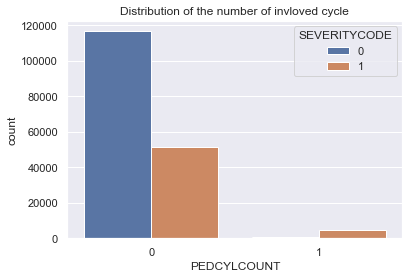

In [94]:
df['PEDCYLCOUNT'].loc[df['PEDCYLCOUNT']>=2]=1

ax_cycle = sns.countplot(x="PEDCYLCOUNT",
                         hue='SEVERITYCODE', 
                         data=df)\
                .set_title("Distribution of the number of invloved cycle")


PEDCOUNT,no,yes
SEVERITYCODE,,
no injury,116553,663
injury,50103,5995


OddsR:  21.034654584406802 p-Value: 0.0


chi-square:  10518.159595095089 p-Value: 0.0000000000000000000000000000000000000000


In [116]:
1 - stats.chi2.cdf(chi2, 1)

0.0

c:\program files\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


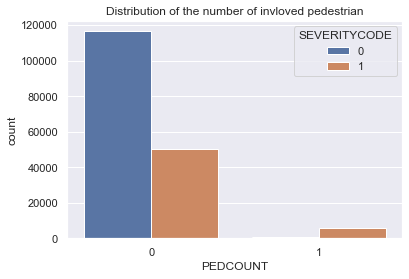

In [135]:
df['PEDCOUNT'].loc[df['PEDCOUNT']>=2]=1

ax_pedestrain = sns.countplot(x="PEDCOUNT",
                              hue='SEVERITYCODE', 
                              data=df)\
                    .set_title("Distribution of the number of invloved pedestrian")

In [136]:
df['PERSONCOUNT'].loc[df['PERSONCOUNT']>=6]=6
df['PERSONCOUNT'].astype(str).value_counts().index

c:\program files\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Index(['2', '3', '4', '1', '5', '0', '6'], dtype='object')

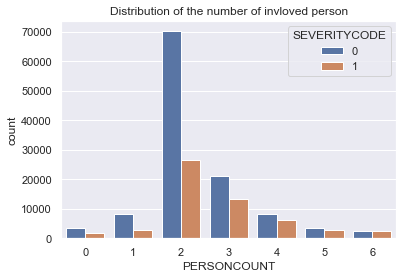

In [132]:
ax_person_involved = sns.countplot(x="PERSONCOUNT",
                                   hue='SEVERITYCODE', 
                                   data=df,
                                   order=[0,1,2,3,4,5,6])\
                        .set_title("Distribution of the number of invloved person")

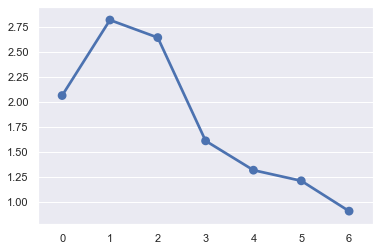

In [133]:
#create a new array with the 'ratio of injury/not injury' and 'number of involed people'
arr_person_count_injury=df['PERSONCOUNT'].loc[df['SEVERITYCODE']==1].value_counts()
arr_person_count_non_injury=df['PERSONCOUNT'].loc[df['SEVERITYCODE']==0].value_counts()
arr_ratio_not_injury_injury=arr_person_count_non_injury/arr_person_count_injury

ax_ration = sns.pointplot(x=arr_ratio_not_injury_injury.index, 
                   y=arr_ratio_not_injury_injury.values, 
                   data=df)

In [35]:
stat.chisquare()

,ration_not_injury_injury,N. of people
0,2.061332,0
1,2.817441,1
2,2.641600,2
3,1.608005,3
4,1.314397,4
5,1.207867,5
6,0.904301,6+


In [134]:
df.corr()

,SEVERITYCODE,X,Y,INC_year,INC_month,INC_day_of_week,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
SEVERITYCODE,1.000000,0.007238,0.025282,0.029020,0.006648,-0.018479,0.133447,0.240556,0.211284,0.031448,0.033552,0.202593,0.028557,0.151806,0.176238,-0.087044
X,0.007238,1.000000,-0.158599,0.009789,-0.000435,-0.008049,0.010258,0.010583,-0.002776,-0.019466,-0.034285,0.007695,-0.010277,-0.006451,0.013520,-0.016647
Y,0.025282,-0.158599,1.000000,-0.022383,0.007671,-0.005855,-0.006005,0.012483,0.028675,0.012165,-0.005135,0.024488,-0.025743,0.017461,0.012793,-0.015676
INC_year,0.029020,0.009789,-0.022383,1.000000,-0.006684,-0.010876,-0.065936,0.028831,0.039737,0.117959,0.000193,-0.011438,-0.039728,0.037959,0.065443,0.223712
INC_month,0.006648,-0.000435,0.007671,-0.006684,1.000000,-0.000213,-0.003072,0.006030,0.007072,0.005053,0.000932,0.003674,0.012134,0.005436,0.008850,0.001601
INC_day_of_week,-0.018479,-0.008049,-0.005855,-0.010876,-0.000213,1.000000,0.068685,-0.022069,-0.027053,-0.019127,0.078247,-0.031196,0.032710,-0.020527,-0.019795,0.016276
PERSONCOUNT,0.133447,0.010258,-0.006005,-0.065936,-0.003072,0.068685,1.000000,-0.032448,-0.049781,0.078151,0.017334,-0.036471,-0.016220,-0.039413,-0.045726,-0.045585
PEDCOUNT,0.240556,0.010583,0.012483,0.028831,0.006030,-0.022069,-0.032448,1.000000,-0.019812,-0.010672,0.013245,0.492664,-0.036662,-0.012329,0.589290,-0.031214
PEDCYLCOUNT,0.211284,-0.002776,0.028675,0.039737,0.007072,-0.027053,-0.049781,-0.019812,1.000000,-0.001309,-0.019921,0.324893,-0.023815,0.689855,0.116034,-0.027453
INATTENTIONIND,0.031448,-0.019466,0.012165,0.117959,0.005053,-0.019127,0.078151,-0.010672,-0.001309,1.000000,-0.034858,-0.032208,-0.058238,0.001081,-0.003933,0.020629
